# Spotify Sequential Skip Prediction Challenge

### Anna Martignano, Daniele Montesi, ID2221
With  this  project  we  would  like  to  use  Deep  Learning  to  model  a  solution  to  the  challenge  ”  Spotify Sequential  Skip  Prediction  Challenge  -  Predict  if  users  will  skip  or  listen  to  the  music  they’re  streamed” published by Spotify in collaboration with WSDM and CrowdAI.

Citing the CrowdAI Challenge Website:The task is to predict whether individual tracks encountered in a listening session will beskippedby a particular user.  In order to do this, complete information about the first half of a user’slistening session is provided, while the prediction is to be carried out on the second half.  

The output of a prediction is abinary variable for each track in the second half of the session indicating if it was skipped or not, with a 1 indicating that the track skipped, and a 0 indicating that the track was not skipped.The  problem  corresponds  hence  to  a  binary  classification.   However,  the  problem  is  hard  and  must take into account all the history of the user tracks listened, making the model that best fits this problem aRecurrent Neural Networks.


### Code organization


The problem will present the following sections:

1. Data exploration 
2. Data filtering/preprocessing 
3. Dataset creation
4. Model reasoning and creation and fitting (First Baseline)
5. Model validation: CV / test/train/valid
6. (Optional): Further feature extraction and further model improvement
    - 

## 1 - Data Exploration

Let's perform basic data esploraton to see which types of columns to leave/to remove

We will start form the session dataset:

In [41]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
%matplotlib inline
pd.set_option('display.max_columns', 500)

path = "dataset/"

The dataset is made of the first 6 csv blocks provided by AICrowd. Each block is ~500MB size csv. For sake of brevity, we only explore one small dataset block here.

Let's now explore the first block and how it does look like:

In [296]:
datas = []
for num in [1,2,3,4,5,6]:
    datas.append(pd.read_csv(path+"{}.csv".format(num)))
# TODO not working
data = pd.concat([datas])

ValueError: cannot copy sequence with size 2990609 to array axis with dimension 21

In [47]:
data.head(5)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [48]:
data.session_length.value_counts(normalize=True, sort=False)

10    0.048739
11    0.047673
12    0.045390
13    0.043300
14    0.041411
15    0.039418
16    0.036413
17    0.034743
18    0.032688
19    0.030534
20    0.599691
Name: session_length, dtype: float64

In [49]:
data.skip_2.value_counts(normalize=True, sort=False)

False    0.48725
True     0.51275
Name: skip_2, dtype: float64

In [50]:
data.hist_user_behavior_reason_start.value_counts(normalize=True, sort=False)

clickrow      1.044396e-01
backbtn       7.584342e-02
trackerror    5.711211e-04
endplay       1.307426e-04
uriopen       3.343801e-07
trackdone     3.321474e-01
playbtn       9.309141e-04
popup         1.671900e-06
remote        9.048324e-04
appload       1.153377e-02
fwdbtn        4.734962e-01
Name: hist_user_behavior_reason_start, dtype: float64

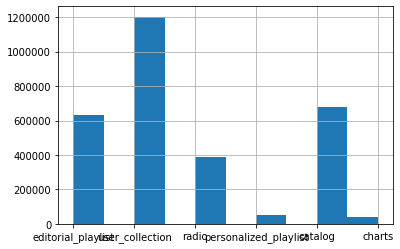

In [51]:
data.context_type.hist()

In [52]:
data.no_pause_before_play.value_counts(normalize=True, sort=False)

0    0.233387
1    0.766613
Name: no_pause_before_play, dtype: float64

In [53]:
data.premium.value_counts()

True     2419034
False     571575
Name: premium, dtype: int64

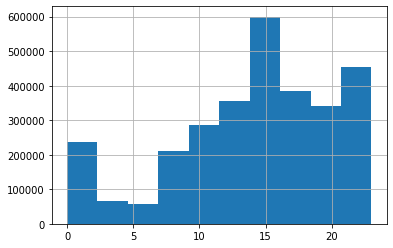

In [54]:
data.hour_of_day.hist()

In [14]:
data.hist_user_behavior_reason_start.value_counts()

fwdbtn        1416042
trackdone      993323
clickrow       312338
backbtn        226818
appload         34493
playbtn          2784
remote           2706
trackerror       1708
endplay           391
popup               5
uriopen             1
Name: hist_user_behavior_reason_start, dtype: int64

In [15]:
data.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day
count,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06
mean,9.312991e+00,1.762598e+01,4.242681e-02,7.666128e-01,1.473198e-01,1.737532e-01,3.958525e-02,4.301465e-02,1.413181e+01
std,5.449092e+00,3.414523e+00,2.015609e-01,4.229866e-01,3.544245e-01,3.788972e-01,3.620769e-01,5.537631e-01,6.036343e+00
min,1.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,1.500000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01
50%,9.000000e+00,2.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01
75%,1.400000e+01,2.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01
max,2.000000e+01,2.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.120000e+02,4.380000e+02,2.300000e+01


## Let's now explore those particular features:  

- (1) the number of times the specific song appeared within the same session, 
- (2) the number of unique songs in this session, and 
- (3) the number of times the specific song appeared over all sessions

If interesting, we are then going to feature-engineer those interesting features, and we log-normalised the last feature in order to alleviate the long tail distribution.

In [18]:
data.head(50)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
5,0_00006f66-33e5-4de7-a324-2d18e439fc1e,6,20,t_c815228b-3212-4f9e-9d4f-9cb19b248184,False,False,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,fwdbtn
6,0_00006f66-33e5-4de7-a324-2d18e439fc1e,7,20,t_e23c19f5-4c32-4557-aa44-81372c2e3705,True,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
7,0_00006f66-33e5-4de7-a324-2d18e439fc1e,8,20,t_0be6eced-f56f-48bd-8086-f2e0b760fdee,True,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
8,0_00006f66-33e5-4de7-a324-2d18e439fc1e,9,20,t_f3ecbd3b-9e8e-4557-b8e0-39cfcd7e65dd,False,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
9,0_00006f66-33e5-4de7-a324-2d18e439fc1e,10,20,t_2af4dfa0-7df3-4b7e-b7ab-353ba48237f9,True,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn


In [19]:
# Check for presence of duplicate tracks into a session
grouped_sess_tracks = data.groupby('session_id')['track_id_clean'].apply(lambda x: x.tolist()).tolist()

In [73]:
dup_track_in_sess = 0
dup = 0
for list_tracks in tqdm(grouped_sess_tracks):
    tot_len = len(list_tracks)
    len_set = len(set(list_tracks))
    if tot_len > len_set:
        dup_track_in_sess += 1
        dup += tot_len-len_set
print("There are", dup_track_in_sess*100/len(grouped_sess_tracks), "% sessions presenting at least a duplicate track suggested")

print("On avg, there are", dup/len(grouped_sess_tracks), "duplicate songs in those sessions")

100%|██████████| 178342/178342 [00:00<00:00, 537938.02it/s]

There are 55.046483722286396 % sessions presenting at least a duplicate track suggested


55% of sessions are recommended a track multiple times. It will be interesting to add this feature in the future processing of data

In [ ]:
.....TODO
.....
for list_tracks in tqdm(grouped_sess_tracks):
    tot_len = len(list_tracks)
    len_set = len(set(list_tracks))
    if tot_len > len_set:
        dup_track_in_sess += 1
        dup += tot_len-len_set

### Tracks dataset:

Also, let's load the Tracks features and explore them

1. Boh
2. Bohoh

In [289]:
tf = pd.read_csv(path+"tf_1.csv")
tf = pd.concat([tf, pd.read_csv(path+"tf_2.csv")])

In [21]:
tf.sample(5)

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
1054920,t_26566e9d-0813-4a21-9e95-63352011e680,213.933334,1974,93.202061,0.011997,0.382128,0.345058,0.446687,5.879724,0.775890,0.962289,3.993095e-04,7,0.814689,-9.103,0.269231,major,0.516802,0.059038,132.639008,4,0.619793,0.056332,-0.318186,0.016325,0.137961,0.644990,-0.083508,-0.261404,-0.525724
1554702,t_227bbc0f-fb73-4112-9c5f-bdb6294f3df0,243.230789,2017,96.235334,0.170864,0.503379,0.459559,0.666467,6.805839,0.974211,0.896823,7.890709e-02,9,0.297750,-1.438,0.751606,major,0.213183,0.094082,130.007996,4,0.606135,-0.279741,0.397582,0.166603,-0.066559,-0.384223,0.216238,0.399613,0.644515
1538046,t_42153208-82fd-4d3e-a001-363df7ce0803,220.440002,2016,98.856853,0.279386,0.177259,0.158867,0.354699,4.418706,0.502555,1.062432,7.950522e-01,9,0.124228,-8.882,0.445274,minor,0.439191,0.033078,135.013000,4,0.023972,0.379811,-0.247889,-0.126700,-0.033048,-0.438400,0.060971,0.132283,0.472966
1796307,t_95059cc6-5063-48af-ba0a-29904b41527b,233.426666,2015,97.565022,0.000161,0.380726,0.304736,0.490593,5.000968,0.833856,1.003603,3.498341e-02,11,0.276421,-3.980,0.790541,major,0.148110,0.035532,90.014000,4,0.209163,0.060603,0.170752,-0.145501,-0.582365,0.122869,0.212625,-0.456924,-0.016519
565965,t_7656b746-fe44-4368-a459-de1a8122cf8a,139.546127,2018,92.732594,0.183506,0.527005,0.605838,0.680425,9.420162,0.514459,1.065799,6.226111e-11,2,0.201042,-8.281,0.461806,major,0.402075,0.193498,138.091003,4,0.226128,-0.869964,0.321989,0.212108,0.122730,-0.285215,-0.037056,-0.516085,0.133688


In [22]:
tf.describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06,1.853311e+06
mean,2.332751e+02,2.009259e+03,9.557489e+01,3.469483e-01,4.617319e-01,4.791076e-01,5.564984e-01,7.848231e+00,5.920562e-01,9.934434e-01,2.070419e-01,5.277245e+00,2.126174e-01,-9.599365e+00,4.995607e-01,4.619059e-01,1.044643e-01,1.200936e+02,3.873969e+00,4.815779e-01,-1.043758e-01,1.544666e-02,5.953267e-02,5.321750e-02,2.276128e-02,7.696181e-04,-2.482889e-02,-1.454615e-03
std,1.086198e+02,1.103782e+01,2.735883e+00,3.426890e-01,1.717286e-01,1.989990e-01,1.858682e-01,2.679272e+00,2.602121e-01,5.522579e-02,3.448191e-01,3.565786e+00,1.924119e-01,5.729013e+00,2.561073e-01,2.508972e-01,1.384147e-01,3.043712e+01,4.859001e-01,2.724881e-01,4.323172e-01,3.607482e-01,2.803449e-01,3.822637e-01,4.107625e-01,2.117887e-01,3.743991e-01,3.872072e-01
min,3.000095e+01,1.950000e+03,9.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.163774e+00,-1.171400e+00,-8.858698e-01,-8.994451e-01,-1.081056e+00,-1.055477e+00,-8.022487e-01,-1.178501e+00
25%,1.768273e+02,2.006000e+03,9.338338e+01,2.661495e-02,3.316267e-01,3.207484e-01,4.327063e-01,5.823167e+00,4.100748e-01,9.691058e-01,2.441339e-07,2.000000e+00,9.681491e-02,-1.170100e+01,2.694064e-01,2.532325e-01,3.627175e-02,9.603400e+01,4.000000e+00,2.522356e-01,-4.082216e-01,-1.760900e-01,-1.470539e-01,-2.350117e-01,-3.121311e-01,-9.005713e-02,-3.157318e-01,-2.703560e-01
50%,2.178956e+02,2.013000e+03,9.575712e+01,2.202808e-01,4.592793e-01,4.794221e-01,5.725539e-01,7.518892e+00,6.264951e-01,1.002416e+00,2.167031e-04,5.000000e+00,1.294323e-01,-8.082000e+00,4.853621e-01,4.549220e-01,5.012720e-02,1.199510e+02,4.000000e+00,4.736272e-01,-3.985430e-02,8.452337e-02,1.289347e-01,6.218451e-02,-1.688186e-02,4.288397e-02,-9.843637e-02,-3.869237e-03
75%,2.671304e+02,2.017000e+03,9.792292e+01,6.529128e-01,5.852491e-01,6.340019e-01,6.975461e-01,9.476678e+00,8.074375e-01,1.029135e+00,3.133383e-01,8.000000e+00,2.699874e-01,-5.789000e+00,7.169492e-01,6.478828e-01,1.014782e-01,1.398710e+02,4.000000e+00,7.052386e-01,1.916600e-01,2.833644e-01,2.745741e-01,2.833329e-01,3.725263e-01,1.477068e-01,2.060100e-01,2.219634e-01
max,1.799815e+03,2.018000e+03,1.000000e+02,9.957964e-01,9.999525e-01,9.850921e-01,9.978067e-01,5.119650e+01,9.999825e-01,1.167801e+00,9.999964e-01,1.100000e+01,1.000000e+00,6.275000e+00,1.000000e+00,9.756333e-01,9.705799e-01,2.499870e+02,5.000000e+00,9.999900e-01,1.000457e+00,8.624035e-01,6.395299e-01,1.202647e+00,1.000955e+00,4.130149e-01,1.092165e+00,1.204228e+00


Total durations are 579463


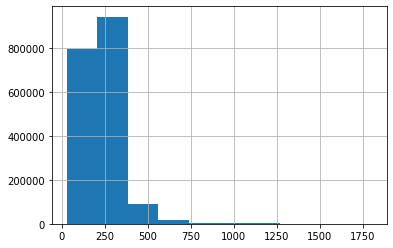

In [30]:
tf.duration.hist();
print("Total durations are", len(set(tf.duration)))

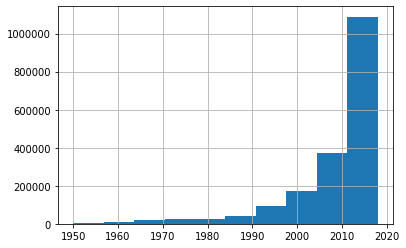

In [31]:
tf.release_year.hist();
# Similar to inverse power law distribution :)

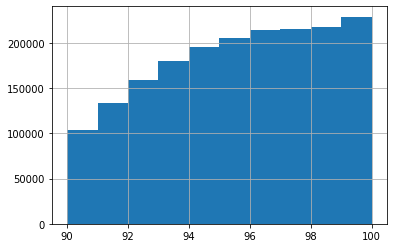

In [24]:
tf.us_popularity_estimate.hist();

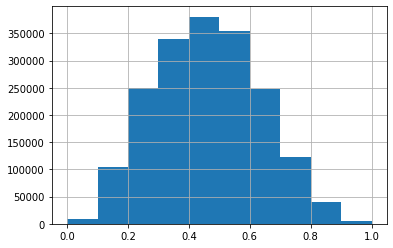

In [25]:
tf.beat_strength.hist();
# So that's a case of gaussian distribution :)

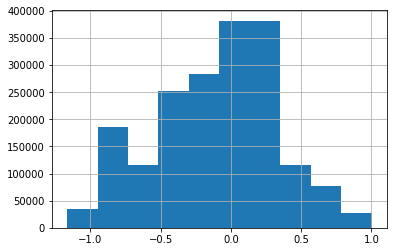

In [26]:
tf.acoustic_vector_0.hist();

There are 7 acoustic vector features, all looking like very similar. For the sake of comprehension in this project, We decide not to consider those feature and to drop them in the immediate

In [27]:
tf.drop(["acoustic_vector_0", 'acoustic_vector_1', "acoustic_vector_2", 'acoustic_vector_3', "acoustic_vector_4", 'acoustic_vector_5', "acoustic_vector_6", 'acoustic_vector_7'], axis=1, inplace=True)

# 2- Dataset Preprocessing

As we can see, the dataset is made of these columns:

- SessionPosition: the position of the track on the session (which can be long up to 20)
- skip_1	skip_2	skip_3	not_skipped: The possible values for skipping. For this purpose, we will drop all of these except for the skip_2, which is the type of skip we are interested on

In [55]:
data["label"] = data["skip_2"]
data.drop(['skip_1', 'skip_2','skip_3', 'not_skipped'], axis=1, inplace=True)

In [88]:

data = data_old.copy()

### Feature Engineering:  
- hour of day -> only 4 values: night-morning-after-evening
- session length - max - med - low


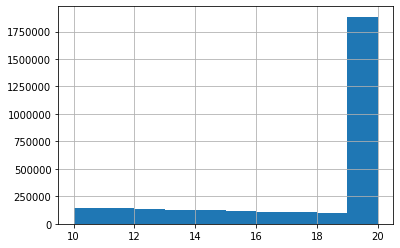

In [73]:
data.session_length.hist()

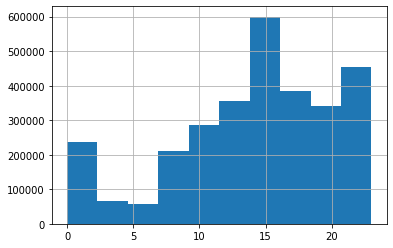

In [66]:
data.hour_of_day.hist()

In [294]:
for i in tqdm(data.index):
    leng = int(data.at[i, "session_length"])
    hour = int(data.at[i, "hour_of_day"])
    yr = int(data.at[i, "release_year"])
    if leng < 15:
        data.at[i, "session_length"] = 0
    elif leng >= 15 and leng<20:
        data.at[i, "session_length"] = 1
    else:
        data.at[i, "session_length"] = 2
        
        
    if hour >7 and hour<=13:
        hour = data.at[i, "hour_of_day"] = 0
    elif hour >13 and hour<20:
        hour = data.at[i, "hour_of_day"] = 1
    elif hour >=20:
        hour = data.at[i, "hour_of_day"] = 2
    else:
        hour = data.at[i, "hour_of_day"] = 3
        

        




  0%|          | 0/2990609 [00:00<?, ?it/s]


KeyError: 'session_length'

In [ ]:
for i in tqdm(tf.index):
    yr = int(tf.at[i, "release_year"])
    dur = int(tf.at[i, "duration"])
    if yr < 1960:
        tf.at[i, "release_year"] = 0
    elif yr >= 1960 and yr < 1970:
        tf.at[i, "release_year"] = 1
    elif yr > 1970 and yr <= 1980:
        tf.at[i, "release_year"] = 2
    elif yr > 1980 and yr <= 1990:
        tf.at[i, "release_year"] = 3
    elif yr > 1990 and yr <= 2000:
        tf.at[i, "release_year"] = 4
    elif yr > 2000 and yr <= 2005:
        tf.at[i, "release_year"] = 5
    elif yr > 2005 and yr <= 2010:
        tf.at[i, "release_year"] = 6
    elif yr > 2010 and yr <= 2015:
        tf.at[i, "release_year"] = 7
        
    if dur < 50:
        tf.at[i, "duration"] = 0
    elif yr >= 50 and yr < 200:
        tf.at[i, "duration"] = 1
    elif yr >= 200 and yr < 350:
        tf.at[i, "duration"] = 2
    elif yr >= 350:
        tf.at[i, "duration"] = 3
        

### Scaling and one-hot-encoding

In [218]:
# Generate dummy columns for categorical variables
# Scaler
print('{0}\t\tNormalising context features...'.format(datetime.datetime.now()))
features = list(set(data.columns) - set(['session_id','track_id_clean','date', 'label', 'session_position', 'train_flag', "context_switch", 'session_length', 'no_pause_before_play','short_pause_before_play','long_pause_before_play','hist_user_behavior_n_seekfwd','hist_user_behavior_is_shuffle','premium','hour_of_day', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end', 'session_length', 'context_type']))
data[features] = StandardScaler().fit_transform(data[features])

features_t = list(set(tf.columns) - set(['track_id',' duration' , 'release_year']))
tf[features_t] = StandardScaler().fit_transform(tf[features_t])

features.append('label')
features.append('session_position')

print('{0}\t\tOne-hot-encoding categorical variables...'.format(datetime.datetime.now()))
data = pd.get_dummies(data, columns = ['context_type'], prefix = ['context_type'])
data = pd.get_dummies(data, columns = ['hist_user_behavior_reason_start'], prefix = ['hist_user_behavior_reason_start'])
data = pd.get_dummies(data, columns = ['hist_user_behavior_reason_end'], prefix = ['hist_user_behavior_reason_end'])
data = pd.get_dummies(data, columns = ['session_length'], prefix = ['session_len'])
# Features to use

tf = pd.get_dummies(datfta, columns = ['release_year'], prefix = ['rel_year'])


2019-12-31 11:37:45.061725		Normalising context features...
2019-12-31 11:37:46.976032		One-hot-encoding categorical variables...


In [219]:
data.head()

,session_id,session_position,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,label,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_popup,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_start_uriopen,hist_user_behavior_reason_end_appload,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_popup,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hist_user_behavior_reason_end_uriopen,session_len_0,session_len_1,session_len_2,session_len_10,session_len_11,session_len_12,session_len_13,session_len_14,session_len_15,session_len_16,session_len_17,session_len_18,session_len_19,session_len_20
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,-0.077677,True,1,2018-07-15,True,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0,1,0,0,0,-0.077677,True,1,2018-07-15,True,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0,1,0,0,0,-0.077677,True,1,2018-07-15,True,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0,1,0,0,0,-0.077677,True,1,2018-07-15,True,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0,1,0,0,0,-0.077677,True,1,2018-07-15,True,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [293]:
tf.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,326.013336,1971,99.582885,0.716209,0.366495,0.332605,0.439835,5.805774,0.238847,1.010700,6.533861e-01,0,0.769258,-17.094,0.199170,major,0.759699,0.033940,100.370003,4,0.223395,0.146012,-0.706908,0.259496,0.481157,0.238427,-0.098389,-0.254960,-0.227383
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,147.813324,1963,97.272035,0.839460,0.362212,0.389829,0.507580,6.845427,0.420476,1.000398,3.941550e-09,0,0.085844,-11.295,0.357639,major,0.747436,0.049856,141.334000,4,0.484702,0.039554,-0.539554,0.105141,0.692589,0.226047,-0.468162,0.164389,-0.769024
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,110.400002,1974,99.620384,0.054673,0.495002,0.589378,0.552311,9.361949,0.842938,0.957766,1.041595e-01,0,0.407325,-9.310,0.304721,major,0.493154,0.071753,138.889999,4,0.818441,0.083863,-0.242108,-0.014258,0.096396,0.417641,-0.050576,-0.204757,-0.172563
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,237.653336,1988,96.796830,0.042606,0.389634,0.359044,0.585673,6.068578,0.665398,0.947322,1.444963e-05,0,0.251502,-12.159,0.702948,major,0.212197,0.029425,133.139008,4,0.594829,0.192498,0.340039,0.034846,-0.389794,0.518381,0.185008,-0.079907,-0.016978
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,174.600006,1987,97.905891,0.249982,0.513640,0.485435,0.635095,7.198735,0.408715,1.014063,5.266880e-01,0,0.218370,-13.813,0.888889,major,0.193438,0.032178,152.212006,4,0.591289,0.270586,-0.411061,0.165898,0.225652,0.335518,-0.036643,-0.016300,-0.446870


# 3- Dataset Creation

The dataset is formed analogously to whast reported in the 5th place solution paper: http://adrem.uantwerpen.be//bibrem/pubs/WSDMCupJeunen2019.pdf

![alt test](pics/model.png)

(https://github.com/olivierjeunen/sequential-skip-prediction/blob/master/src/RNN.py in generate_model() )

where Xh and Xf are respectively 2 matrices for the session history and future. 
### The steps to the dataset creation are:

1. Merge track features and session features
2. Split based on the time, and drop that feature (with other useless features)
3. create the History-Matrix and Future Matrix. Create duplicate files for each new song to predict its label 

## Keep only tracks present in the training set

Then, we will explore how frequent they are :)

In [291]:
set_tracks_present = set(data.track_id_clean.values)
tracks_set = set(tf.track_id)
print("There are", len(set_tracks_present), "tracks in the dataset \nInstead, in the tracks_data there are", len(tracks_set) )


There are 319008 tracks in the dataset 
Instead, in the tracks_data there are 3706388


In [292]:
print("Missing tracks on dataset:", len(set(set_tracks_present)-tracks_set)*100/len(set(set_tracks_present)), "%")

Missing tracks on dataset: 0.0 %


In [106]:
#TODO Correct: must output a number
data['date'] = pd.to_datetime(data['date'])
data["hist_user_behavior_is_shuffle"] = data['hist_user_behavior_is_shuffle'].astype(np.int64)
data["premium"] = data['premium'].astype(np.int64)
data["label"] = data['label'].astype(np.int64)
data[""] = data[''].astype(np.int64)
data[""] = data[''].astype(np.int64)
data[""] = data[''].astype(np.int64)

In [263]:
# Sorting by session & position of track in session
data.sort_values(['session_id','session_position', "date", "hour_of_day"], inplace = True)

In [92]:
tf["track_id_clean"] = tf["track_id"]
tf.drop("track_id", axis=1, inplace=True)

In [223]:
dataset = data.merge(tf, on = 'track_id_clean', how = 'left')

In [288]:
dataset.tail(20)

,session_id,session_position,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,label,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_popup,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_start_uriopen,hist_user_behavior_reason_end_appload,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_popup,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hist_user_behavior_reason_end_uriopen,session_len_0,session_len_1,session_len_2,session_len_10,session_len_11,session_len_12,session_len_13,session_len_14,session_len_15,session_len_16,session_len_17,session_len_18,session_len_19,session_len_20,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence
2990589,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,1,t_d4b66e92-8d10-4105-85d4-951d42aced81,0,0,0,0,0,-0.077677,True,5,2018-07-15,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2990590,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,2,t_8e663394-33eb-4402-b4d1-697ba092bdc1,0,1,0,0,0,-0.077677,True,5,2018-07-15,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2990591,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,3,t_566e4706-9c20-4fd5-87bd-91481b2482c7,0,1,0,0,0,-0.077677,True,5,2018-07-15,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,245.228973,2017.0,99.997813,0.333693,0.726618,0.693413,0.704892,9.221917,0.824062,0.988479,2.804037e-05,2.0,0.146981,-4.188,0.696498,major,0.318955,0.189924,73.000999,4.0,0.669464
2990592,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,4,t_141c632a-48bb-4de8-b89d-d18be89d30be,0,1,0,0,0,-0.077677,True,5,2018-07-15,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,245.063400,2000.0,99.994384,0.205497,0.607622,0.702931,0.607341,10.942751,0.713618,0.973328,7.166522e-09,5.0,0.300726,-6.007,0.410920,minor,0.441160,0.278250,96.619003,4.0,0.826793
2990593,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,5,t_093e55f8-0231-4cb7-8198-129792733462,0,1,0,0,0,-0.077677,True,5,2018-07-15,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,179.144852,2017.0,99.949738,0.403466,0.650920,0.670910,0.688726,9.598331,0.770265,1.054060,1.962900e-02,4.0,0.132601,-4.658,0.616580,minor,0.393570,0.037887,74.953003,4.0,0.214041
2990594,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,6,t_112019bd-0b8e-4751-92b9-9affacb7da01,0,1,0,0,0,-0.077677,True,5,2018-07-15,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2990595,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,7,t_b0100dfa-b3e5-4f6a-a1ad-e67c610588a1,0,1,0,0,0,-0.077677,True,5,2018-07-15,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,

## Organize the dataset into samples. 

Let n be the maximal session length. With k = ⌊n/2].

As session lengths can vary, shorter sessions are padded with zeroes to match the size of the longest ones. Historical tracks Xh are padded before the track sequence, and future tracks Xf are padded after the track sequence.

Input of the network is made of 2 np.arrays-matrices:
- **session_histories** old_matrix R^ (f x k x t), where k is the first half of the features. Made of all the features of thefirst half of the tracks
- **session_futures** new_matrix: R^ (f x (n-k) x t), where n is the total length of features. It is made of all the features in the second half of the tracks (without their labels)

To do so, create 4 lists containing:
1. session_histories as np.array
2. session_futures as np.array
3. session_labels as lists
4. sizes as list of int




In [269]:
max_seq_len = 20
def process_sessions(data, sess_features, track_feature_list, label_index):
    session_histories = []
    session_futures   = []
    session_labels    = []
    session_sizes     = []
    for key, subgroup in tqdm(data.groupby('session_id', sort = False)):
        # Split session in two
        half = int(np.floor(len(subgroup) / 2.0))
        first = subgroup[sess_features + track_feature_list].head(half).values
        
        second = subgroup[sess_features + track_feature_list].tail(subgroup.shape[0] - half)
                
        # Generate labels
        current_labels = second[label_index].astype(int).values
        
        second = second.values
        
        # Generate padding for session history
        padding = np.zeros((int(max_seq_len / 2.0) - first.shape[0], len(sess_features) + len(track_feature_list)))
        
        #stack all in a np array
        session_history = np.vstack([padding,first])
        
        # Generate padding for session future
        padding = np.zeros((int(max_seq_len / 2.0) - second.shape[0], len(track_feature_list)))
        session_future = np.vstack([second[:,-len(track_feature_list):],padding])
        
        # Save results
        session_histories.append(session_history)
        session_futures.append(session_future)
        s_l = list(current_labels)
        s_l = [x[0] for x in current_labels]
        times=int(max_seq_len / 2.0) - current_labels.shape[0]
        if times > 0:
            for i in range(times):
                np.array(s_l.append(0))
        session_labels.append(s_l)
        session_sizes.append(len(current_labels))

    return session_histories, session_futures, session_labels, session_sizes 


In [273]:
sf = list(data.columns.values)
for el in ["track_id_clean", "session_id", "date"]:
    sf.remove(el)
tf_f = list(tf.columns.values)
for el in ["track_id_clean"]:
    tf_f.remove(el)

history, future, labels, session_len = process_sessions(dataset[:2000], tf_f ,sf, ["label"])




  0%|          | 0/118 [00:00<?, ?it/s]


  5%|▌         | 6/118 [00:00<00:01, 56.55it/s]


 15%|█▌        | 18/118 [00:00<00:01, 66.58it/s]


 29%|██▉       | 34/118 [00:00<00:01, 80.35it/s]


 42%|████▏     | 50/118 [00:00<00:00, 94.09it/s]


 53%|█████▎    | 63/118 [00:00<00:00, 101.54it/s]


 63%|██████▎   | 74/118 [00:00<00:00, 103.12it/s]


 72%|███████▏  | 85/118 [00:00<00:00, 94.54it/s] 


 81%|████████  | 95/118 [00:00<00:00, 93.79it/s]


100%|██████████| 118/118 [00:01<00:00, 113.97it/s]


In [274]:
labels

[[1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0,

In [277]:
history

[array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, 1, 0, 0, 0, 0, 0,
         -0.07767700307007487, True, 1, True, False, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [236.7963714599609, 2018.0, 99.89672801894189,
         0.06181062757968904, 0.6548038125038147, 0.7356613874435424,
         0.8773934841156006, 11.308750152587892, 0.7268283367156982,
         1.0256357192993164, 1.0313149090279694e-07, 7.0,
         0.1043219193816185, -5.318999767303467, 0.8247663378715515,
         'minor', 0.13139137625694275, 0.06115787103772164,
         130.03799438476562, 4.0, 0.3371524214744568, 2, 0, 1, 0, 0, 0,
         -0.07767700307007487, True, 1, True, False, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [231.266

In [298]:
dataset = [history, future, labels, session_len]

### Problem: concept drift: must order by data and split according to that

As we are dealing with temporal data, new songs start to appear throughout the data, songs’ popularities change over time, et cetera. This phenomenon, widely known as concept drift, can heavily influence the performance of learning algorithms, if not dealt with properly.

Links: G. Widmer and M. Kubat. 1996. Learning in the Presence of Concept Drift and Hidden Contexts. Machine Learning 23, 1 (01 Apr 1996), 69–101.

In [302]:
# Split train-test-valid according to date ordering - TODO CHECK CUT
num_s = len(dataset[0])

print("there are", num_s, "samples")

train = [l[:int(num_s*0.7)] for l in dataset]

valid = [l[int(num_s*0.7):int(num_s*0.9)] for l in dataset]

test = [l[:int(num_s*0.9)] for l in dataset]

there are 118 samples


We generate n − k predictions for every session, including those that consist of less than n tracks. To mitigate this issue, we pad the label vector y with zeroes, analogously to the padding performed with Xf . However, note that these padded labels and predictions are not considered when evaluating the model 

# 4- Model Fitting ad Evaluation Metrics 

To evaluate the performance of our solution we are going to use the same metrics proposed for this competition. 

The primary one is the Mean Average Accuracy:

![alt test](pics/maa.png)

The metric aims to weight higher the correct good prediction, instead of predicting the


- T is the number of tracks to be predicted for the given session
- A(i) is the accuracy at position i of the sequence
- L(i) is the boolean indicator for if the i‘th prediction was correct

Moreover, we are going to use the accuracy for the second half of the dataset


In [8]:
def evaluation_MAA_FA(label_matrix, prediction_matrix):
    '''
    Return MAA and first-prediction-accuracy
    :param sizes:    A list of session sizes
    :param labels:      The correct labels list [ [1,0,1,1,0,... size_of_truth_labels], ...]
    :param predictions: The predicted labels list [ [1,0,1,0,0,... size_of_predicted_labels], ...]
    :returns:           Mean Average Precision and First Prediction Accuracy
    '''
    # Initialize scores
    score = 0.0
    first_acc = 0.0
    # For every session
    for label_row, prediction_row in zip(label_matrix, prediction_matrix):
        # Set variables
        n_correct    = 0
        session      = 0.0
        # For the first 'size' predictions
        for i in range(len(label_row)):        
            # If the prediction is correct:
            if label_row[i] == prediction_row[i]:
                # Increase counter of correct predictions
                n_correct += 1
                session += n_correct / (i + 1)
                # If first prediction
                if i == 0:
                    first_acc += 1
        # Save session score
        score += session / len(label_row)
    return score/len(label_matrix), first_acc/len(label_matrix)


## Model to be used 

(taken from https://github.com/olivierjeunen/sequential-skip-prediction/blob/master/src/RNN.py )



In [ ]:
def generate_model(history, future):
    h_input  = keras.layers.Input(shape = (history.shape[1], history.shape[2]))
    h_subnet = keras.layers.Dropout(.35)(h_input)
    h_subnet = keras.layers.CuDNNLSTM(256, return_sequences = True)(h_subnet)
    h_subnet = keras.layers.CuDNNLSTM(256)(h_subnet)

    f_input  = keras.layers.Input(shape = (future.shape[1], future.shape[2]))
    f_subnet = keras.layers.Dropout(.35)(f_input)
    f_subnet = keras.layers.CuDNNLSTM(128, return_sequences = True)(f_subnet)
    f_subnet = keras.layers.CuDNNLSTM(128)(f_subnet)

    td_subnet = keras.layers.TimeDistributed(keras.layers.Dense(32))(f_input)
    td_subnet = keras.layers.Flatten()(td_subnet)

    concat = keras.layers.concatenate([h_subnet, f_subnet, td_subnet])
    concat = keras.layers.Dropout(.25)(concat)

    dense1  = keras.layers.Dense(512, activation = 'elu')(concat)
    dense1  = keras.layers.BatchNormalization()(dense1)
    dense2  = keras.layers.Dense(512, activation = 'elu')(dense1)

    outputs = [keras.layers.Dense(1, activation = 'sigmoid')(dense2) for _ in range(10)]

    model = keras.Model(inputs = [h_input, f_input], outputs = outputs)
    
    return model